# NeurIPS_Open-Polymer-Prediction-2025

### Goal 
Predicting polymer properties with machine learning to accelerate sustainable materials research.

### Data
In this competition, your task is to use polymer structure data (SMILES) to predict five key chemical properties derived from molecular dynamics simulation: glass transition temperature (Tg), fractional free volume (FFV), thermal conductivity (Tc), polymer density, and radius of gyration (Rg). Successfully predicting these properties is crucial for scientists to accelerate the design of novel polymers with targeted characteristics, which can be used in various applications.

Refer `TOX - EDA.ipynb` for EDA

### QSPR Models 

In [1]:
#import
import numpy as np
import pandas as pd
from rdkit import Chem
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, DataStructs

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score

## XGBOOST - Descriptors

In [2]:
def generate_2d_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {desc_name: func(mol) for desc_name, func in Descriptors.descList}

In [3]:
def generate_3d_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None 
    mol = Chem.AddHs(mol)  

    try:
        AllChem.EmbedMolecule(mol, AllChem.ETKDG())
        AllChem.UFFOptimizeMolecule(mol)

        descriptors_3d = {
            "radius_of_gyration": rdMolDescriptors.CalcRadiusOfGyration(mol),
            "asphericity": rdMolDescriptors.CalcAsphericity(mol),
            "spherocity_index": rdMolDescriptors.CalcSpherocityIndex(mol),
            "eccentricity": rdMolDescriptors.CalcEccentricity(mol),
            "NPR1": rdMolDescriptors.CalcNPR1(mol),
            "NPR2": rdMolDescriptors.CalcNPR2(mol),
            "PMI1": rdMolDescriptors.CalcPMI1(mol),
            "PMI2": rdMolDescriptors.CalcPMI2(mol),
            "PMI3": rdMolDescriptors.CalcPMI3(mol),
        }

        return descriptors_3d

    except:
        return None 

In [5]:
data = pd.read_csv("train.csv")

In [6]:
#Rg
datafile = data[['SMILES','Density']]
datafile.dropna(inplace=True)

C:\Users\shasa\AppData\Local\Temp\ipykernel_29924\1722609453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile.dropna(inplace=True)


In [7]:
smiles_list = datafile["SMILES"].to_list()
activity_values = datafile["Density"].to_list()

In [8]:
datafile

,SMILES,Density
10,*c1ccc(-c2ccc3c(c2)C(CCCCCCC#N)(CCCCCCC#N)c2cc...,0.901123
11,*CC(*)c1ccc(C(=O)O)c(C(=O)O)c1,1.184354
46,*CC(*)C(=O)Oc1ccccc1C,1.061864
64,*CC(*)C(=O)Oc1ccccc1,1.109389
88,*CC(C)S(*)(=O)=O,1.293315
...,...,...
7943,*CC(*)C1CC=CCC1,0.842083
7944,*CC(*)Cl,1.263489
7945,*CCCCCC(=O)O*,1.002696
7952,*CCCC(=O)NCc1ccc(CNC(=O)CCCO*)cc1,1.107946


In [9]:
data = []
for smiles in smiles_list:
    descriptors_2d = generate_2d_descriptors(smiles)
    descriptors_3d = generate_3d_descriptors(smiles)

    if descriptors_2d and descriptors_3d:
        combined_descriptors = {**descriptors_2d, **descriptors_3d}
        combined_descriptors["SMILES"] = smiles
        data.append(combined_descriptors)

[00:16:34] UFFTYPER: Unrecognized atom type: *_ (0)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (31)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (0)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (31)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (0)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (3)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (0)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (3)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (0)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (3)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (0)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (3)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (0)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (3)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (0)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (3)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (0)
[00:16:34] UFFTYPER: Unrecognized atom type: *_ (5)
[00:16:34] 

****
Invariant Violation
bad lower bound
Violatio

In [10]:
df = pd.DataFrame(data)

In [11]:
data = datafile.merge(df,on="SMILES").drop_duplicates()

In [12]:
data.columns

Index(['SMILES', 'Density', 'MaxAbsEStateIndex', 'MaxEStateIndex',
       'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt',
       'HeavyAtomMolWt',
       ...
       'fr_urea', 'radius_of_gyration', 'asphericity', 'spherocity_index',
       'eccentricity', 'NPR1', 'NPR2', 'PMI1', 'PMI2', 'PMI3'],
      dtype='object', length=221)

In [13]:
data.shape

(596, 221)

In [14]:
data = data.drop("SMILES",axis=1)

In [15]:
cor = abs(data.corr()["Density"])

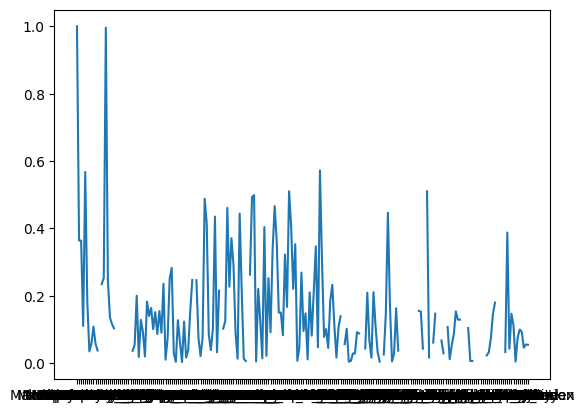

In [16]:
plt.plot(abs(data.corr()["Density"]))

In [17]:
cor

Density              1.000000
MaxAbsEStateIndex    0.363637
MaxEStateIndex       0.363637
MinAbsEStateIndex    0.110090
MinEStateIndex       0.567246
                       ...   
NPR1                 0.099277
NPR2                 0.092834
PMI1                 0.045650
PMI2                 0.054974
PMI3                 0.054162
Name: Density, Length: 220, dtype: float64

### XGBOOST Regressor

In [18]:
final = data[cor[cor>0.2].index]
#final = data.copy()

In [19]:
#final["SMILES"] = data["SMILES"]

In [20]:
final.columns

Index(['Density', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinEStateIndex',
       'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge',
       'MinAbsPartialCharge', 'HallKierAlpha', 'Kappa2', 'Kappa3', 'PEOE_VSA4',
       'PEOE_VSA6', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA5', 'SMR_VSA7',
       'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA5',
       'SlogP_VSA6', 'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA2',
       'EState_VSA5', 'EState_VSA7', 'EState_VSA9', 'VSA_EState1',
       'VSA_EState10', 'VSA_EState5', 'VSA_EState7', 'VSA_EState8',
       'VSA_EState9', 'FractionCSP3', 'NOCount', 'NumAromaticCarbocycles',
       'NumAromaticRings', 'NumHAcceptors', 'NumHeteroatoms',
       'NumRotatableBonds', 'MolLogP', 'fr_NH0', 'fr_N_O', 'fr_alkyl_halide',
       'fr_benzene', 'fr_halogen', 'fr_unbrch_alkane'],
      dtype='object')

In [21]:
final.shape

(596, 50)

In [22]:
#final.drop('SMILES', axis=1,inplace=True)

In [23]:
final.isin([np.inf, -np.inf]).sum().values

array([ 0,  0,  0,  0, 46,  4, 46,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int64)

In [24]:
final.replace([np.inf, -np.inf], np.nan, inplace=True)
final.fillna(final.mean(), inplace=True) 

C:\Users\shasa\AppData\Local\Temp\ipykernel_29924\666826105.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\shasa\AppData\Local\Temp\ipykernel_29924\666826105.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.fillna(final.mean(), inplace=True)


In [25]:
scaler = MinMaxScaler() #scaling
final_scale = pd.DataFrame(scaler.fit_transform(final.drop('Density', axis=1)),columns=final.columns.to_list()[1:])

In [26]:
X = final_scale
y = final['Density']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [52]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [27]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)  
y_pred_test = model.predict(X_test)   

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("Training Performance:")
print(f"RMSE: {rmse_train:.4f}")
print(f"R²: {r2_train:.4f}\n")
print("Test Performance:")
print(f"RMSE: {rmse_test:.4f}")
print(f"R²: {r2_test:.4f}")

Training Performance:
RMSE: 0.0009
R²: 1.0000

Test Performance:
RMSE: 0.0560
R²: 0.8278


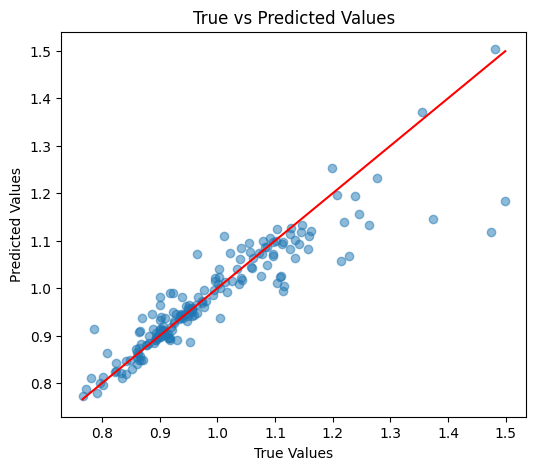

In [28]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

In [29]:
idx = model.feature_importances_.argsort()

<BarContainer object of 10 artists>

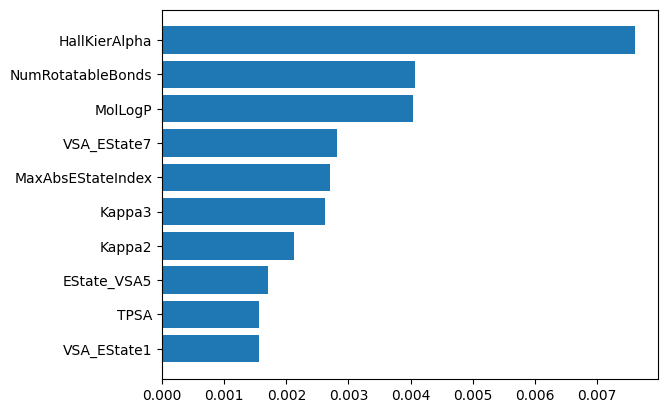

In [30]:
plt.barh(X_train.columns[idx][20:30],model.feature_importances_[idx][20:30])

## NN - Fingerprint

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [32]:
def elastic_net_loss(output, target, model, l1_lambda, l2_lambda):
    mse_loss = nn.MSELoss()(output, target)  
    
    l1_penalty = sum(p.abs().sum() for p in model.parameters())  
    l2_penalty = sum((p ** 2).sum() for p in model.parameters()) 
    
    return mse_loss + l1_lambda * l1_penalty + l2_lambda * l2_penalty

In [33]:
class NNRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3,hidden_dim4, dropout_rate):
        super(NNRegressor, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3) 
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4) 
        self.fc5 = nn.Linear(hidden_dim4, 1)
        
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc5(x)
        return x 

class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_pred, y_true):
        return torch.sqrt(self.mse(y_pred, y_true))

class NNDataset(Dataset):
    def __init__(self, df, label_column):
        self.embeddings = torch.tensor(df.drop(columns=[label_column]).values, dtype=torch.float32)
        self.labels = torch.tensor(df[label_column].values, dtype=torch.float32).unsqueeze(1) 

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [34]:
def train_model(model, data_loader, optimizer, l1_lambda, l2_lambda, epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, targets in data_loader:
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Compute elastic net loss
            loss = elastic_net_loss(outputs, targets, model, l1_lambda, l2_lambda)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / len(data_loader):.4f}")

In [35]:
def evaluate_model(model, data_loader, l1_lambda, l2_lambda):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            
            mse_loss = nn.MSELoss()(outputs, labels)

            l1_penalty = sum(p.abs().sum() for p in model.parameters())
            l2_penalty = sum((p ** 2).sum() for p in model.parameters())

            loss = mse_loss + l1_lambda * l1_penalty + l2_lambda * l2_penalty
            total_loss += loss.item()

            all_preds.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
    print(f"Test RMSE Loss: {rmse:.4f}")

    r2_test = r2_score(all_labels, all_preds)
    print(f"Test R²: {r2_test:.4f}")

    plt.figure(figsize=(6, 5))
    plt.scatter(all_labels, all_preds, alpha=0.5)
    plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("True vs Predicted Values")
    plt.show()

In [36]:
import pandas as pd

In [37]:
datafile = pd.read_csv("train.csv")

In [38]:
datafile.shape

(7973, 7)

In [39]:
data=datafile.copy()

In [41]:
#Rg
datafile = data[['SMILES','Density']]
datafile.dropna(inplace=True)

C:\Users\shasa\AppData\Local\Temp\ipykernel_29924\1722609453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datafile.dropna(inplace=True)


In [42]:
datafile.shape

(613, 2)

In [43]:
smiles_list = datafile["SMILES"].to_list()
activity_values = datafile["Density"].to_list()

In [44]:
def smiles_to_fingerprint(smiles, radius=1, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [45]:
fingerprints = np.array([smiles_to_fingerprint(s) for s in smiles_list if smiles_to_fingerprint(s) is not None])

[00:19:20] DEPRECATION WARNING: please use MorganGenerator
[00:19:20] DEPRECATION WARNING: please use MorganGenerator
[00:19:20] DEPRECATION WARNING: please use MorganGenerator
[00:19:20] DEPRECATION WARNING: please use MorganGenerator
[00:19:20] DEPRECATION WARNING: please use MorganGenerator
[00:19:20] DEPRECATION WARNING: please use MorganGenerator
[00:19:20] DEPRECATION WARNING: please use MorganGenerator
[00:19:20] DEPRECATION WARNING: please use MorganGenerator
[00:19:20] DEPRECATION WARNING: please use MorganGenerator
[00:19:20] DEPRECATION WARNING: please use MorganGenerator
[00:19:20] DEPRECATION WARNING: please use MorganGenerator
[00:19:20] DEPRECATION WARNING: please use MorganGenerator
[00:19:20] DEPRECATION WARNING: please use MorganGenerator
[00:19:20] DEPRECATION WARNING: please use MorganGenerator
[00:19:20] DEPRECATION WARNING: please use MorganGenerator
[00:19:20] DEPRECATION WARNING: please use MorganGenerator
[00:19:20] DEPRECATION WARNING: please use MorganGenerat

In [46]:
datafile.reset_index(drop=True,inplace=True)

In [47]:
final2 = pd.concat([datafile,pd.DataFrame(fingerprints)],axis=1).drop("SMILES",axis=1)

In [48]:
final2

,Density,0,1,2,3,4,5,6,7,8,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.901123,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.184354,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.061864,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.109389,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.293315,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,0.842083,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
609,1.263489,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
610,1.002696,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
611,1.107946,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
input_dim = 2048
hidden_dim1 = 2048*2
hidden_dim2 = 1024*3
hidden_dim3 = 1024
hidden_dim4 = 1000
dropout_rate = 0.5
epochs = 100

model = NNRegressor(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, dropout_rate)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

l1_lambda = 0.0001
l2_lambda = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

label_column = "Density"
train_df, test_df = train_test_split(final2, test_size=0.3, random_state=42)

train_dataset = NNDataset(train_df, label_column)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)

test_dataset = NNDataset(test_df, label_column)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=True)

best_loss = float("inf")
best_model_state = None

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        l1_reg = sum(p.abs().sum() for p in model.parameters())
        loss = criterion(outputs, targets) + l1_lambda * l1_reg

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    #best model
    if avg_train_loss < best_loss:
        best_loss = avg_train_loss
        best_model_state = model.state_dict()

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

model.load_state_dict(best_model_state)
print(f"Best model loaded with Train Loss: {best_loss:.4f}")

Epoch 1/100, Train Loss: 23.5163
Epoch 2/100, Train Loss: 21.1921
Epoch 3/100, Train Loss: 19.0947
Epoch 4/100, Train Loss: 17.3604
Epoch 5/100, Train Loss: 15.7308
Epoch 6/100, Train Loss: 14.2060
Epoch 7/100, Train Loss: 12.7660
Epoch 8/100, Train Loss: 11.4281
Epoch 9/100, Train Loss: 10.1802
Epoch 10/100, Train Loss: 9.0142
Epoch 11/100, Train Loss: 7.9448
Epoch 12/100, Train Loss: 6.9630
Epoch 13/100, Train Loss: 6.0753
Epoch 14/100, Train Loss: 5.2626
Epoch 15/100, Train Loss: 4.5437
Epoch 16/100, Train Loss: 3.9205
Epoch 17/100, Train Loss: 3.3880
Epoch 18/100, Train Loss: 2.9485
Epoch 19/100, Train Loss: 2.5770
Epoch 20/100, Train Loss: 2.2631
Epoch 21/100, Train Loss: 1.9964
Epoch 22/100, Train Loss: 1.7821
Epoch 23/100, Train Loss: 1.6049
Epoch 24/100, Train Loss: 1.4780
Epoch 25/100, Train Loss: 1.3810
Epoch 26/100, Train Loss: 1.3015
Epoch 27/100, Train Loss: 1.2213
Epoch 28/100, Train Loss: 1.1523
Epoch 29/100, Train Loss: 1.0907
Epoch 30/100, Train Loss: 1.0394
Epoch 31/1

Test RMSE Loss: 0.1070
Test R²: 0.6068


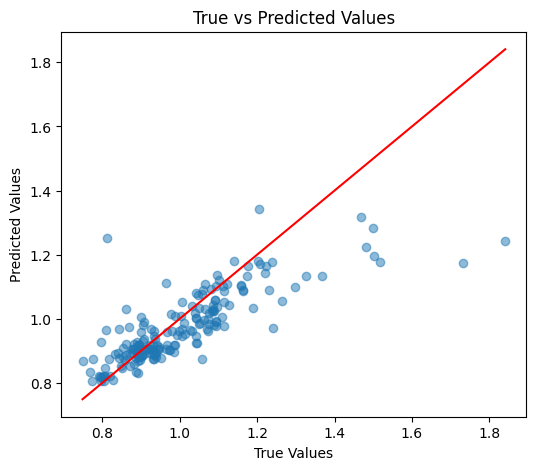

In [69]:
evaluate_model(model, test_loader, l1_lambda, l2_lambda)